In [1]:
import os
from est_lib.util.obspy_util import *
from est_lib.dataset.seismic_dataset_new import EQDataset, get_device
from obspy import UTCDateTime as dt
from tqdm.notebook import tqdm

In [2]:
# Torch and NN Imports
import torch
from est_lib.nn.cp_line_simple import cp_line_simple

In [3]:
sta_list = ['HOLB','PACB','WOSB']
cha_list = ['HHE','HHN','HHZ']

event1 = ('6.3mw',50.6081,-129.9656,"2019-12-25T03:36:01.578000Z")
event2 = ('6.8',+49.347,-129.214,"2018-10-22T06:16:28.160000")
event3 = ('4.2 mb',+49.028,-128.5804,"2018-12-09T18:14:23.700000Z")
event4 = ('6.0  mww',+50.517,-129.757,"2019-12-23T20:56:23.555000Z")

In [4]:
# Save
filepath = os.path.abspath('../est_lib/_data/eq')

In [5]:
# Inventory
inv = inventory_retriever(network="CN",
                              sta_list=sta_list,
                              level='response')
inv_file = inventory_writer(inv,
                            os.path.join(filepath,'inv.xml'),
                            file_format="STATIONXML")

# Event 1
ev_1_train_x = stream_retriever(event_time = dt(event1[3]),
                          seconds_before = 600,
                          seconds_after = 1500,
                          network="CN",
                          sta_list=sta_list[0:2],
                          channel_list=cha_list)

ev_1_train_y = stream_retriever(event_time = dt(event1[3]),
                          seconds_before = 600,
                          seconds_after = 1500,
                          network="CN",
                          sta_list=sta_list[-1:],
                          channel_list=cha_list)

# Event2
ev_2_test_x = stream_retriever(event_time = dt(event4[3]),
                          seconds_before = 600,
                          seconds_after = 1500,
                          network="CN",
                          sta_list=sta_list[0:2],
                          channel_list=cha_list)

ev_2_test_y = stream_retriever(event_time = dt(event4[3]),
                          seconds_before = 600,
                          seconds_after = 1500,
                          network="CN",
                          sta_list=sta_list[-1:],
                          channel_list=cha_list)

In [6]:
# Remove Response
ev_1_train_x.remove_response(inventory=inv)
ev_1_train_y.remove_response(inventory=inv)
ev_2_test_x.remove_response(inventory=inv)
ev_2_test_y.remove_response(inventory=inv)

3 Trace(s) in Stream:
CN.WOSB..HHE | 2019-12-23T20:46:23.560000Z - 2019-12-23T21:11:23.550000Z | 100.0 Hz, 150000 samples
CN.WOSB..HHN | 2019-12-23T20:46:23.560000Z - 2019-12-23T21:11:23.550000Z | 100.0 Hz, 150000 samples
CN.WOSB..HHZ | 2019-12-23T20:46:23.560000Z - 2019-12-23T21:11:23.550000Z | 100.0 Hz, 150000 samples

In [7]:
# Train Files
train_x_f_path = os.path.join(filepath,'train_x.npy')
train_x_file = stream_data_writer(ev_1_train_x,
                              inv,
                              train_x_f_path,
                              sta_list[0:2],
                              cha_list)
        
train_y_f_path = os.path.join(filepath,'train_y.npy')
train_y_file = stream_data_writer(ev_1_train_y,
                              inv,
                              train_y_f_path,
                              sta_list[-1:],
                              cha_list)

In [8]:
# Test Files
test_x_f_path = os.path.join(filepath,'test_x.npy')
test_x_file = stream_data_writer(ev_2_test_x,
                              inv,
                              test_x_f_path,
                              sta_list[0:2],
                              cha_list)
        
test_y_f_path = os.path.join(filepath,'test_y.npy')
test_y_file = stream_data_writer(ev_2_test_y,
                              inv,
                              test_y_f_path,
                              sta_list[-1:],
                              cha_list)

In [9]:
# Load Dataset
train_dataset = EQDataset(inv_file,
                    train_x_file,train_y_file,
                    sta_list=sta_list,
                    chan_list=cha_list,
                    ip_dim=3,
                    num_nodes=3,
                    seq_length=500)

test_dataset = EQDataset(inv_file,
                    test_x_file,test_y_file,
                    sta_list=sta_list,
                    chan_list=cha_list,
                    ip_dim=3,
                    num_nodes=3,
                    seq_length=500)

In [12]:
# Data Loader
batch_len = 1000
train_loader = torch.utils.data.DataLoader(train_dataset,batch_size=batch_len)
test_loader = torch.utils.data.DataLoader(test_dataset,batch_size=batch_len)

In [14]:
# Model
net = cp_line_simple(num_in_nodes=2,feat_size=3)
net = net.to(get_device())

# Start Functions and Code for Train/Eval Routine

In [15]:
num_epoch = 2
optimizer = torch.optim.Adam(net.parameters())
loss1 = torch.nn.MSELoss()
loss2 = torch.nn.MSELoss()
loss3 = torch.nn.MSELoss()

In [16]:
test_loss_list = list()
for e in tqdm(range(num_epoch)):
    net.train()
    for i,batch in tqdm(enumerate(train_loader)):
        net.zero_grad()
        x = batch[0]
        y = batch[1]
        # Forward Pass
        op = net(x)
        
        # Loss
        lx = loss1(op[0],y[:,:,0])
        ly = loss1(op[1],y[:,:,1])
        lz = loss1(op[2],y[:,:,2])
        t_loss = lx+ly+lz
        t_loss.backward()
        optimizer.step()
    # One Test Loop
    net.eval()
    test_losses = torch.zeros(batch_len)
    for i,batch in enumerate(test_loader):
        with torch.no_grad():
            x = batch[0]
            y = batch[1]
            # Forward Pass
            op = net(x)
            
            # Loss
            lx = loss1(op[0],y[:,:,0])
            ly = loss1(op[1],y[:,:,1])
            lz = loss1(op[2],y[:,:,2])
            t_loss = lx+ly+lz
            test_losses[i] = t_loss
    t_loss = torch.mean(test_losses)
    test_loss_list.append(t_loss)

  0%|          | 0/2 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline

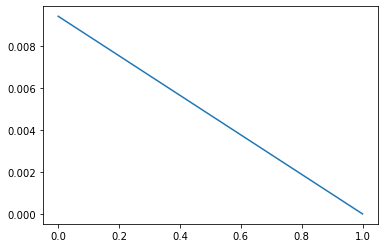

In [18]:
plt.figure()
plt.plot(test_loss_list)
plt.show()

In [21]:
# Save Prediction and Plot
pred = list()
net.eval()
test_losses = torch.zeros(batch_len)
for i,batch in tqdm(enumerate(test_loader)):
    with torch.no_grad():
        x = batch[0]
        y = batch[1]
        # Forward Pass
        op = net(x)
        pred.append(op)
            
        # Loss
        lx = loss1(op[0],y[:,:,0])
        ly = loss1(op[1],y[:,:,1])
        lz = loss1(op[2],y[:,:,2])
        t_loss = lx+ly+lz
        test_losses[i] = t_loss
    t_loss = torch.mean(test_losses)
    test_loss_list.append(t_loss)

0it [00:00, ?it/s]

In [34]:
def write_op_to_numpy_streams(obj,batch_size,features):
    for i,op in tqdm(enumerate(obj)):
        if i==0:
            tempx = op[0].detach().cpu().numpy()
            tempy = op[1].detach().cpu().numpy()
            tempz = op[2].detach().cpu().numpy()
        else:
            tempx = np.concatenate((tempx,op[0].detach().cpu().numpy()))
            tempy = np.concatenate((tempy,op[1].detach().cpu().numpy()))
            tempz = np.concatenate((tempz,op[2].detach().cpu().numpy()))
    return tempx,tempy,tempz

In [35]:
final = write_op_to_numpy_streams(pred,batch_len,3)

0it [00:00, ?it/s]

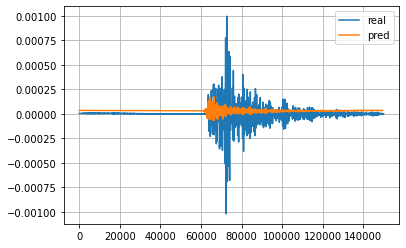

In [58]:
plt.figure()
plt.plot(ev_2_test_y[0].data,label='real')
plt.plot(final[0],label='pred')
plt.grid()
plt.legend()
plt.show()

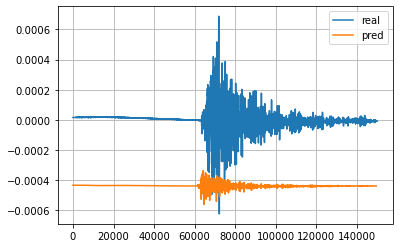

In [59]:
plt.figure()
plt.plot(ev_2_test_y[1].data,label='real')
plt.plot(final[1],label='pred')
plt.grid()
plt.legend()
plt.show()

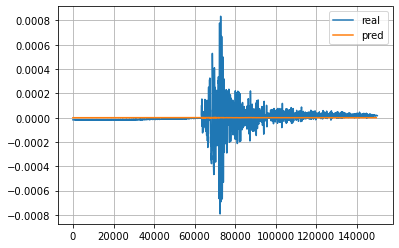

In [60]:
plt.figure()
plt.plot(ev_2_test_y[2].data,label='real')
plt.plot(final[2],label='pred')
plt.grid()
plt.legend()
plt.show()